Sentiment Analysis(NLP)

In [144]:
# pip install scikit-plot

In [145]:
import warnings
warnings.filterwarnings('ignore')
!pip install scikit-plot
!pip install wordcloud
!pip install textblob  

import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
df = pd.read_csv("/content/Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [147]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [148]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [149]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [150]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [151]:
text_df.Review.isna().sum()

3811

In [152]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [153]:
text_df['Recommended'].unique()

array([0, 1])

In [154]:
text_df['Recommended'].value_counts(normalize=True)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

In [155]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [156]:
text_df['Review_length'].describe()

count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

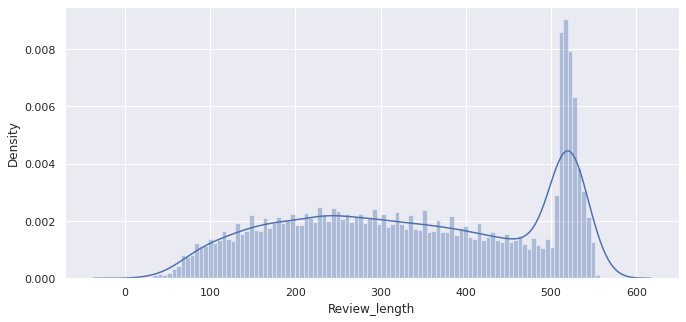

In [157]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

In [158]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

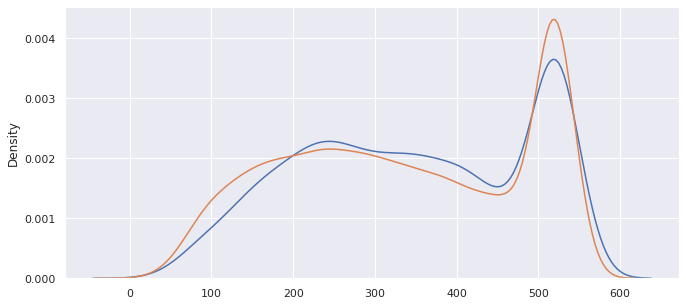

In [159]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [160]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [161]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [162]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

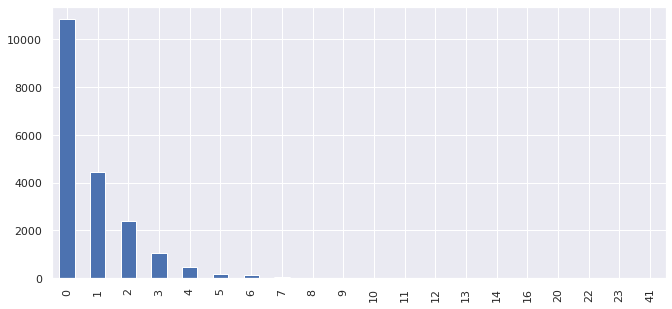

In [163]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [164]:
text_df[text_df['count_exc']== 41].index

Int64Index([3301], dtype='int64')

In [165]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

In [166]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


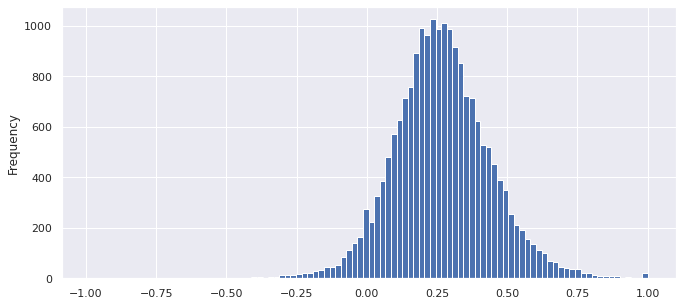

In [167]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [168]:
text_prep = text_df.copy()

In [169]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [170]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [171]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

In [172]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [173]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [174]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
7    goes ordered had try used top pair went is nic...
8    Flattering love get runs little ordered flatte...
Name: Review, dtype: object

In [175]:
nltk.download('stopwords')
print(stopwords.words('english')[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
stop = stopwords.words('english')
stop.append("i'm")

In [177]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [178]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [179]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [180]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [181]:
print(text_prep['Review'][3301])

#'Beautiful and unique. Love this top, just received it today.
# \nit is a very artistic interpretation for a casual top.
# \nthe blue is gorgeous!
# \nthe unique style of the peplm and the details on the front set this apart!
# \nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.
# \nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nordered my usual size and it fits perfectly.'

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [182]:
print(text_prep['Review'][267]) 

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


In [183]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [184]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
5    petite love reese petite tall long full overwh...
6    aded last see look went pale gorgeous turns ma...
Name: Review, dtype: object

In [185]:
print(text_prep['Review'][267]) 

nice short tall say fits true short tall wish came


In [186]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


In [187]:
porter = PorterStemmer()

In [188]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [189]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [190]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
5    [petit, love, rees, petit, tall, long, full, o...
6    [ade, last, see, look, went, pale, gorgeou, tu...
Name: Review, dtype: object

In [191]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [192]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


In [193]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [194]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


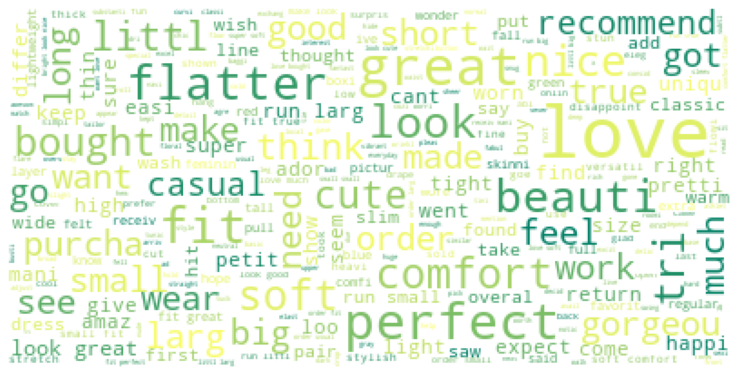

In [195]:
!pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

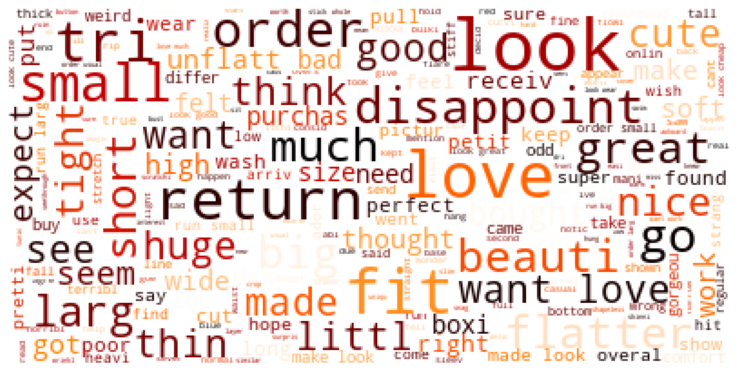

In [196]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [197]:
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [198]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [199]:
bow_transformer = CountVectorizer(text_vectorizing_process)
# a = text_vectorizing_process
# bow_transformer0 = CountVectorizer()
# bow_transformer = CountVectorizer(a)

TypeError: ignored

In [ ]:
bow_transformer.fit(text_prep['Review'])

In [ ]:
print(text_prep['Review'].iloc[3])

In [ ]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)
#3507=Love
#4438=petit

In [ ]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

In [ ]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

In [ ]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)

In [ ]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

In [ ]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

In [ ]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

In [ ]:
print(messages_tfidf[:1]) 

In [ ]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

In [ ]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

In [ ]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

In [ ]:
X.shape

In [ ]:
X.describe()

In [ ]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.value_counts(normalize=True)

In [ ]:
y_test.value_counts(normalize=True)

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

In [ ]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno") 

In [ ]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

In [ ]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [ ]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

In [ ]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

In [ ]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

In [ ]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

In [ ]:
gs_lr_model.best_params_

In [ ]:
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

In [ ]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression') 

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=555)

ada_model = AdaBoostClassifier(base_estimator=dt, learning_rate=0.001, n_estimators=1000, random_state=222)
ada_model.fit(X_train ,y_train)


In [ ]:
test_predictions = ada_model.predict(X_test)
print(report(y_test, test_predictions, ada_model.classes_ ))

In [ ]:
skplt.metrics.plot_roc(y_test, ada_model.predict_proba(X_test), 
                       title='ROC Curves - AdaBoost') 

In [ ]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

In [ ]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

In [ ]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 


In [ ]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

In [ ]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')


In [ ]:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

In [ ]:
#Train
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [ ]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

In [ ]:
#Test
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

Topic modeling guide (GSDM,LDA,LSI)

In [200]:
import warnings
warnings.filterwarnings('ignore')
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install gensim

import numpy as np 
import pandas as pd

import sys
# sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-bdzezywa
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-bdzezywa
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4601 sha256=16ae84e3dc0010ae07034c2794388da5e978041c12acac54a0a23d6997fd5a65
  Stored in directory: /tmp/pip-ephem-wheel-cache-0zkgr0r_/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [243]:
data = pd.read_csv('/content/tripadvisor_hotel_reviews.csv', encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [244]:
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  104.37582353228247


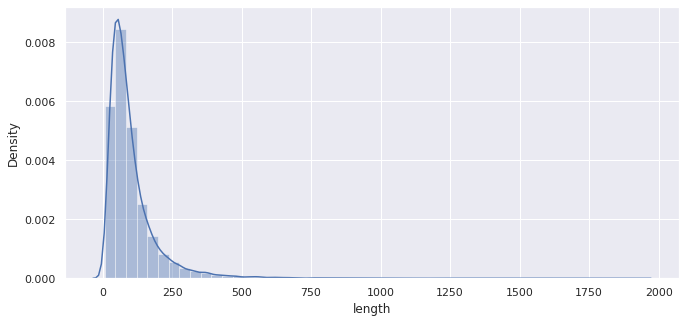

In [245]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

In [246]:
data['review_list'] = data.Review.values.tolist()

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

<>:4: DeprecationWarning:

invalid escape sequence \s

<>:4: DeprecationWarning:

invalid escape sequence \s

<>:4: DeprecationWarning:

invalid escape sequence \s

<ipython-input-246-770aad7c9498>:4: DeprecationWarning:

invalid escape sequence \s



In [247]:
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text


In [248]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [249]:
import gensim
from gensim.utils import simple_preprocess


tokens_reviews = list(sent_to_words(data['review_list']))
tokens_reviews = make_n_grams(tokens_reviews)

In [250]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

In [251]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)


In stage 0: transferred 15707 clusters with 6 clusters populated
In stage 1: transferred 8404 clusters with 6 clusters populated
In stage 2: transferred 5359 clusters with 6 clusters populated
In stage 3: transferred 4332 clusters with 6 clusters populated
In stage 4: transferred 3525 clusters with 6 clusters populated
In stage 5: transferred 3052 clusters with 6 clusters populated
In stage 6: transferred 2765 clusters with 6 clusters populated
In stage 7: transferred 2618 clusters with 6 clusters populated
In stage 8: transferred 2441 clusters with 6 clusters populated
In stage 9: transferred 2416 clusters with 6 clusters populated
In stage 10: transferred 2398 clusters with 6 clusters populated
In stage 11: transferred 2314 clusters with 6 clusters populated
In stage 12: transferred 2279 clusters with 6 clusters populated
In stage 13: transferred 2215 clusters with 6 clusters populated
In stage 14: transferred 2194 clusters with 6 clusters populated
In stage 15: transferred 2178 clus

In [252]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [253]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [3937  762 4059 2793 2727 6213]

Most important clusters (by number of docs inside): [5 2 0 3 4 1]

Cluster 5 : [('resort', 8791), ('beach', 8742), ('food', 7381), ('pool', 6495), ('restaurant', 5595), ('night', 5442), ('people', 4973), ('want', 3838), ('drink', 3571), ('bar', 3436)]

Cluster 2 : [('night', 2389), ('breakfast', 1776), ('bed', 1568), ('walk', 1503), ('restaurant', 1465), ('view', 1374), ('area', 1280), ('bathroom', 1118), ('price', 1033), ('floor', 1032)]

Cluster 0 : [('breakfast', 2520), ('night', 2408), ('walk', 2009), ('restaurant', 1460), ('area', 1312), ('city', 1269), ('view', 1257), ('bed', 1238), ('bathroom', 1189), ('price', 1034)]

Cluster 3 : [('night', 2090), ('bed', 1310), ('bathroom', 1070), ('breakfast', 950), ('desk', 869), ('tell', 849), ('pay', 838), ('floor', 835), ('price', 768), ('problem', 669)]

Cluster 4 : [('breakfast', 1897), ('night', 1358), ('walk', 1232), ('florence', 918), ('restaurant', 842), ('bathroom', 8

In [254]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [255]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [256]:
result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

,Text,Topic,Rating,Lemma-text
0,nice hotel expensive parking got good deal sta...,type 4,4,"[parking, deal, anniversary, evening, advice, ..."
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond_member, decide, chain, shoot,..."
2,nice rooms not 4* experience hotel monaco seat...,type 2,3,"[experience, positive, bathroom, suite, bed, h..."
3,"unique, great stay, wonderful time hotel monac...",type 2,5,"[stroll, downtown, shopping, area, pet, sign, ..."
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[game, downfall, view, building, complain, web..."


In [257]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()


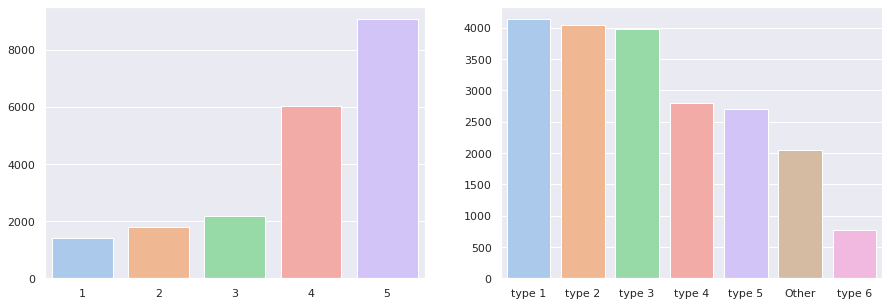

In [258]:
import matplotlib.pyplot as plt

rating_counts = result.Rating.value_counts()
types_counts = result.Topic.value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
rating = sns.barplot(x = rating_counts.index, y = rating_counts.values, palette="pastel", ax=ax[0])
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel", ax=ax[1])


In [259]:
fig = px.sunburst(result, path=['Topic', 'Rating'], title='Topics and ratings', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [260]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

,Text,Topic,Rating,Lemma-text,len
0,nice hotel expensive parking got good deal sta...,type 4,4,"[parking, deal, anniversary, evening, advice, ...",87
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond_member, decide, chain, shoot,...",250
2,nice rooms not 4* experience hotel monaco seat...,type 2,3,"[experience, positive, bathroom, suite, bed, h...",217
3,"unique, great stay, wonderful time hotel monac...",type 2,5,"[stroll, downtown, shopping, area, pet, sign, ...",89
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[game, downfall, view, building, complain, web...",191


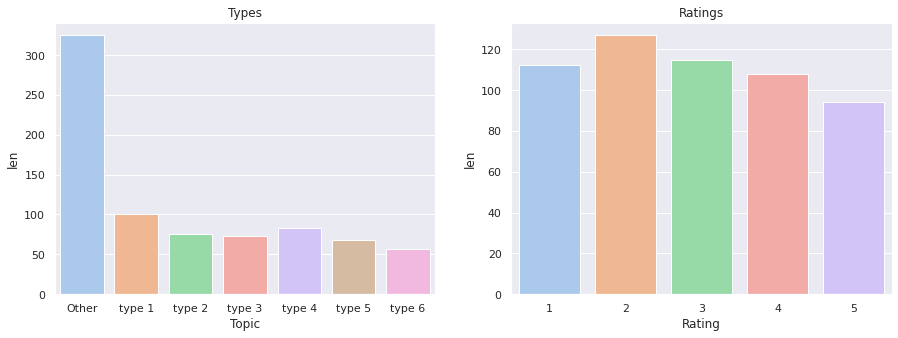

In [261]:
types_len = result.groupby(by=['Topic']).mean()
rating_len = result.groupby(by=['Rating']).mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
ax[1].set_title('Ratings')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])
rating = sns.barplot(x = rating_len.index, y = rating_len['len'], palette="pastel", ax=ax[1])

In [262]:
result.Rating = pd.to_numeric(result.Rating)

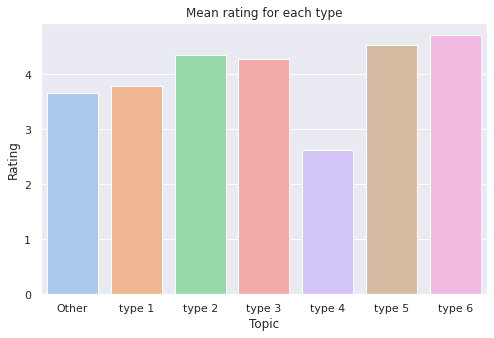

In [263]:
types_rating = result.drop('len', axis='columns').groupby(by=['Topic']).mean()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean rating for each type')
types = sns.barplot(x = types_rating.index, y = types_rating.Rating, palette="pastel")

In [264]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [265]:
result = result.drop('Lemma-text', axis=1)

In [266]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

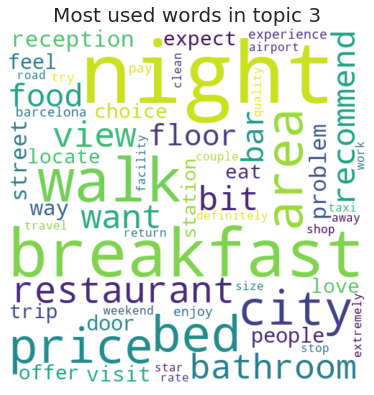

In [267]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

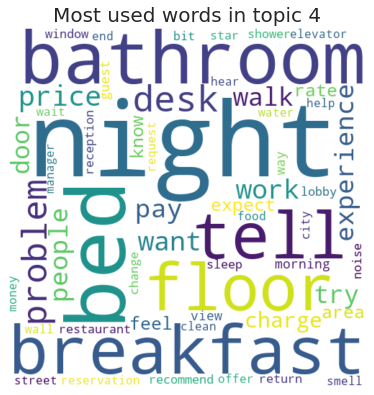

In [268]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

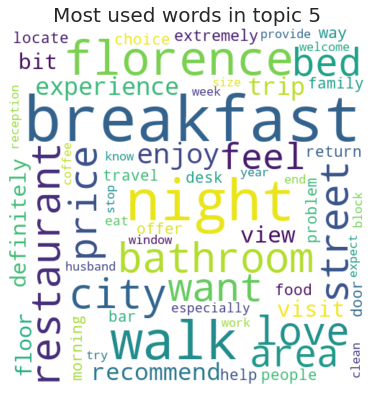

In [269]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

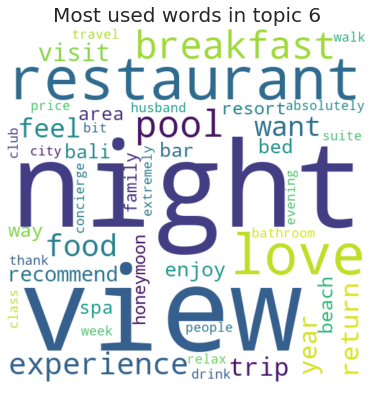

In [270]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

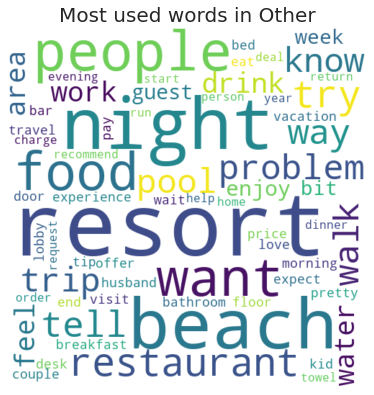

In [271]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

In [272]:
from gensim import corpora
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [273]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [283]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

model created
0.4325001659163211


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

model created
0.4632436700066665


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

model created
0.48309233273799057


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

model created
0.523029273790638


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin in

model created
0.5032699475803716


In [284]:
import matplotlib.pyplot as plt

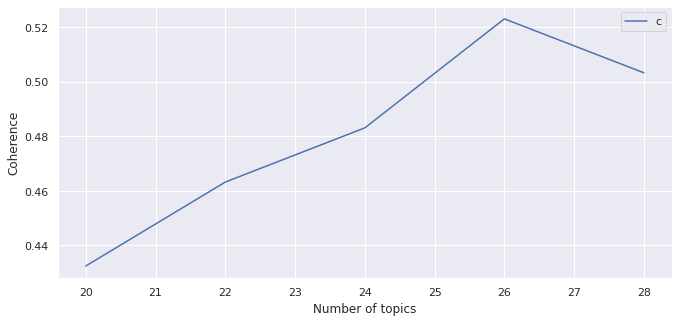

In [285]:
limit, start, step = 30, 20, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [286]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [287]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

NameError: ignored

In [ ]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        print('model created')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values_Lsi(dictionary = id2word, corpus=corpus_tfidf, texts=texts, start = 2, limit = 30, step =2)


In [ ]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()